In [4]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Author: Selvaria
# Severstal的预处理，用于判断每张图是否有缺陷的模型
# https://www.kaggle.com/xhlulu/severstal-predict-missing-masks-95-val-acc

import pandas
import numpy as np

train_df = pandas.read_csv(r'D:\data\Kaggle\Severstal/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
#train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['Missing_defect'] = train_df['EncodedPixels'].isnull()
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,Missing_defect
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,False
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,True
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,True
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,True
4,00031f466.jpg_1,NaN,00031f466.jpg,True


In [5]:
#统计每张图不包含缺陷类别的总数，注意是不包含的数量，即'Missing_defect'=4时，代表没有缺陷

train_nan_df = train_df.groupby(by='ImageId', axis=0).agg('sum')
train_nan_df.reset_index(inplace=True)
print(len(train_nan_df))
train_nan_df.head()

12568


,ImageId,Missing_defect
0,0002cc93b.jpg,3.0
1,00031f466.jpg,4.0
2,000418bfc.jpg,4.0
3,000789191.jpg,4.0
4,0007a71bf.jpg,3.0


In [7]:
train_nan_df['allMissing'] = (train_nan_df['Missing_defect'] == 4).astype(int) #如果Missing_defect=4，allMissing列值等于1
train_nan_df.head()

,ImageId,Missing_defect,allMissing
0,0002cc93b.jpg,3.0,0
1,00031f466.jpg,4.0,1
2,000418bfc.jpg,4.0,1
3,000789191.jpg,4.0,1
4,0007a71bf.jpg,3.0,0


3.0    6239
4.0    5902
2.0     425
1.0       2
Name: Missing_defect, dtype: int64

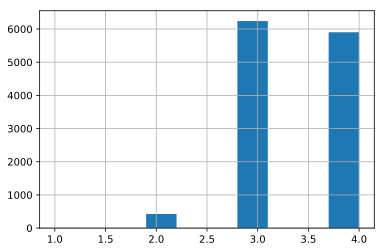

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

train_nan_df['Missing_defect'].hist()
train_nan_df['Missing_defect'].value_counts()

In [17]:
import cv2
import os

def load_img(code, base, resize=True):
    path = r'{}/{}'.format(base, code)
    #path = f'{base}/{code}'
    img = cv2.imread(path) #读取原始图像
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#将新图应用于原始图像（叠加），转换为RGB显示模式
    if resize:
        img = cv2.resize(img, (224, 224))  #将原始图像调整为224*224(缩放/拉伸，并非是截取一段)
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [20]:
#建立临时训练文件夹
from tqdm import tqdm

train_path = 'D:/data/Kaggle/Severstal/tmp/train'
validate_path(train_path)

for code in tqdm(train_nan_df['ImageId']):
    img = load_img(
        code,
        base='D:\data\Kaggle\Severstal/train_imgs'
    )
    path = code.replace('.jpg', '')
    cv2.imwrite(f'{train_path}/{path}.png', img)

100%|███████████████████████████████████████████████████████████████████████████| 12568/12568 [02:05<00:00, 100.33it/s]


In [21]:
#在dataframe里对格式稍作调整，且png图像损失更小
train_nan_df['ImageId'] = train_nan_df['ImageId'].apply(lambda x: x.replace('.jpg', '.png')) 

In [24]:
#设置训练集和验证集

from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
train_path = 'D:/data/Kaggle/Severstal/tmp/train'

train_gen = ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=0.15
    )

train_data = train_gen.flow_from_dataframe(
        train_nan_df, 
        directory=train_path,
        x_col='ImageId', 
        y_col='allMissing', 
        class_mode='other',
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        subset= 'training' #("training" 或 "validation")，如果在 ImageDataGenerator 中设置了 validation_split
    )

validation_data = train_gen.flow_from_dataframe(
        train_nan_df, 
        directory=train_path,
        x_col='ImageId', 
        y_col='allMissing', 
        class_mode='other',
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        subset= 'validation' #("training" 或 "validation")，如果在 ImageDataGenerator 中设置了 validation_split
    )


Found 10683 images.
Found 1885 images.


In [34]:
# 建模

from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam

densenet = DenseNet121(
    include_top=False,
    input_shape=(256,256,3),
    #weights = 'imagenet'
    weights='D:/data/Kaggle/Severstal/DenseNet-BC-121-32-no-top.h5'
)

model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D()) #全局平均池化层，可以理解为优化数据的全连接层。对整个网路在结构上做正则化防止过拟合。其直接剔除了全连接层中黑箱的特征，直接赋予了每个channel实际的内别意义
model.add(layers.BatchNormalization()) #批量标准化，不用在原数据上标准化。加快训练速度；同时也意味着允许使用大点的学习率，加快收敛过程。每层后都加。
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(5e-5),
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
__________

In [35]:
#模型运算

total_steps = len(train_nan_df) / BATCH_SIZE

checkpoint = ModelCheckpoint(
    'D:/data/Kaggle/Severstal/pre_model_2.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, #若设置为True，则只保存模型权重，否则将保存整个模型（包括模型结构，配置信息等）
    mode='auto' #‘auto/min/max’之一，在save_best_only=True时决定性能最佳模型的评判准则，例如，当监测值为val_acc时，模式应为max，当检测值为val_loss时，模式应为min。在auto模式下，评价准则由被监测值的名字自动推断。
)

reduce_lr = ReduceLROnPlateau( #自动减小学习率的回调函数，默认facor=0.1
    monitor='val_loss',
    patience=5, #当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
    verbose=0,
    min_lr=1e-6 #下限
)

history = model.fit_generator(
    train_data,
    steps_per_epoch=total_steps * 0.85,
    validation_data=validation_data,
    validation_steps=total_steps * 0.15,
    epochs=25,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/25
167/166 [==============================] - ETA: 3:37:36 - loss: 1.2875 - acc: 0.43 - ETA: 2:58:26 - loss: 1.3814 - acc: 0.39 - ETA: 2:44:58 - loss: 1.2717 - acc: 0.42 - ETA: 2:37:45 - loss: 1.1560 - acc: 0.47 - ETA: 2:33:06 - loss: 1.1458 - acc: 0.46 - ETA: 2:29:28 - loss: 1.1110 - acc: 0.48 - ETA: 2:26:50 - loss: 1.1083 - acc: 0.48 - ETA: 2:24:34 - loss: 1.1064 - acc: 0.48 - ETA: 2:22:42 - loss: 1.1446 - acc: 0.47 - ETA: 2:20:56 - loss: 1.1070 - acc: 0.48 - ETA: 2:19:19 - loss: 1.1118 - acc: 0.50 - ETA: 2:17:48 - loss: 1.0924 - acc: 0.50 - ETA: 2:16:23 - loss: 1.0720 - acc: 0.50 - ETA: 2:15:09 - loss: 1.0534 - acc: 0.50 - ETA: 2:13:56 - loss: 1.0724 - acc: 0.50 - ETA: 2:12:47 - loss: 1.0695 - acc: 0.50 - ETA: 2:11:48 - loss: 1.0661 - acc: 0.50 - ETA: 2:10:42 - loss: 1.0484 - acc: 0.50 - ETA: 2:09:40 - loss: 1.0357 - acc: 0.51 - ETA: 2:08:36 - loss: 1.0331 - acc: 0.51 - ETA: 2:07:32 - loss: 1.0147 - acc: 0.52 - ETA: 2:06:30 - loss: 1.0039 - acc: 0.52 - ETA: 2:05:28 - loss: 0

167/166 [==============================] - ETA: 2:19:37 - loss: 0.4433 - acc: 0.78 - ETA: 2:18:40 - loss: 0.5384 - acc: 0.75 - ETA: 2:18:00 - loss: 0.6677 - acc: 0.75 - ETA: 2:17:19 - loss: 0.7110 - acc: 0.75 - ETA: 2:16:43 - loss: 0.6957 - acc: 0.75 - ETA: 2:15:57 - loss: 0.6542 - acc: 0.77 - ETA: 2:15:10 - loss: 0.6803 - acc: 0.76 - ETA: 2:14:20 - loss: 0.6660 - acc: 0.75 - ETA: 2:13:33 - loss: 0.6481 - acc: 0.76 - ETA: 2:12:40 - loss: 0.6430 - acc: 0.75 - ETA: 2:11:49 - loss: 0.6289 - acc: 0.75 - ETA: 2:10:54 - loss: 0.6087 - acc: 0.75 - ETA: 2:09:59 - loss: 0.6082 - acc: 0.75 - ETA: 2:09:08 - loss: 0.6056 - acc: 0.75 - ETA: 2:08:17 - loss: 0.6060 - acc: 0.75 - ETA: 2:07:26 - loss: 0.5897 - acc: 0.75 - ETA: 2:06:37 - loss: 0.5799 - acc: 0.76 - ETA: 2:05:48 - loss: 0.5885 - acc: 0.75 - ETA: 2:04:59 - loss: 0.5828 - acc: 0.75 - ETA: 2:04:07 - loss: 0.5735 - acc: 0.75 - ETA: 2:03:18 - loss: 0.5647 - acc: 0.76 - ETA: 2:02:26 - loss: 0.5576 - acc: 0.76 - ETA: 2:01:36 - loss: 0.5627 - acc

167/166 [==============================] - ETA: 2:24:40 - loss: 0.6832 - acc: 0.81 - ETA: 2:24:00 - loss: 0.5060 - acc: 0.82 - ETA: 2:22:58 - loss: 0.5396 - acc: 0.79 - ETA: 2:21:58 - loss: 0.5302 - acc: 0.79 - ETA: 2:22:07 - loss: 0.5524 - acc: 0.79 - ETA: 2:21:02 - loss: 0.5184 - acc: 0.81 - ETA: 2:20:07 - loss: 0.4901 - acc: 0.82 - ETA: 2:19:26 - loss: 0.4730 - acc: 0.82 - ETA: 2:18:22 - loss: 0.4351 - acc: 0.83 - ETA: 2:17:12 - loss: 0.4211 - acc: 0.83 - ETA: 2:16:16 - loss: 0.4047 - acc: 0.84 - ETA: 2:15:20 - loss: 0.3798 - acc: 0.85 - ETA: 2:14:23 - loss: 0.3929 - acc: 0.84 - ETA: 2:13:31 - loss: 0.4041 - acc: 0.84 - ETA: 2:12:35 - loss: 0.4056 - acc: 0.83 - ETA: 2:11:42 - loss: 0.4096 - acc: 0.84 - ETA: 2:10:50 - loss: 0.4173 - acc: 0.84 - ETA: 2:09:58 - loss: 0.4249 - acc: 0.83 - ETA: 2:09:06 - loss: 0.4298 - acc: 0.83 - ETA: 2:08:13 - loss: 0.4275 - acc: 0.83 - ETA: 2:07:17 - loss: 0.4378 - acc: 0.82 - ETA: 2:06:20 - loss: 0.4307 - acc: 0.82 - ETA: 2:05:27 - loss: 0.4287 - acc

167/166 [==============================] - ETA: 2:24:02 - loss: 0.3235 - acc: 0.87 - ETA: 2:22:20 - loss: 0.3422 - acc: 0.82 - ETA: 2:21:41 - loss: 0.3373 - acc: 0.84 - ETA: 2:20:48 - loss: 0.3772 - acc: 0.82 - ETA: 2:19:53 - loss: 0.3938 - acc: 0.83 - ETA: 2:19:11 - loss: 0.3872 - acc: 0.83 - ETA: 2:18:37 - loss: 0.3654 - acc: 0.84 - ETA: 2:17:31 - loss: 0.3803 - acc: 0.83 - ETA: 2:16:28 - loss: 0.3533 - acc: 0.85 - ETA: 2:15:33 - loss: 0.3758 - acc: 0.84 - ETA: 2:14:44 - loss: 0.3553 - acc: 0.85 - ETA: 2:13:48 - loss: 0.3771 - acc: 0.84 - ETA: 2:12:55 - loss: 0.3603 - acc: 0.85 - ETA: 2:12:07 - loss: 0.3532 - acc: 0.85 - ETA: 2:12:56 - loss: 0.3571 - acc: 0.85 - ETA: 2:13:18 - loss: 0.3549 - acc: 0.84 - ETA: 2:13:22 - loss: 0.3526 - acc: 0.84 - ETA: 2:12:23 - loss: 0.3538 - acc: 0.84 - ETA: 2:11:20 - loss: 0.3610 - acc: 0.83 - ETA: 2:10:25 - loss: 0.3572 - acc: 0.84 - ETA: 2:09:21 - loss: 0.3608 - acc: 0.83 - ETA: 2:08:19 - loss: 0.3849 - acc: 0.82 - ETA: 2:07:15 - loss: 0.3814 - acc

167/166 [==============================] - ETA: 2:22:48 - loss: 0.3142 - acc: 0.84 - ETA: 2:22:17 - loss: 0.2333 - acc: 0.90 - ETA: 2:20:49 - loss: 0.2838 - acc: 0.89 - ETA: 2:19:53 - loss: 0.2850 - acc: 0.89 - ETA: 2:19:06 - loss: 0.3110 - acc: 0.87 - ETA: 2:18:13 - loss: 0.3288 - acc: 0.87 - ETA: 2:17:22 - loss: 0.3314 - acc: 0.87 - ETA: 2:16:33 - loss: 0.3242 - acc: 0.87 - ETA: 2:15:38 - loss: 0.3511 - acc: 0.86 - ETA: 2:14:47 - loss: 0.3324 - acc: 0.87 - ETA: 2:13:55 - loss: 0.3486 - acc: 0.86 - ETA: 2:13:12 - loss: 0.3540 - acc: 0.86 - ETA: 2:12:24 - loss: 0.3572 - acc: 0.86 - ETA: 2:11:32 - loss: 0.3418 - acc: 0.86 - ETA: 2:10:39 - loss: 0.3608 - acc: 0.86 - ETA: 2:09:43 - loss: 0.3604 - acc: 0.86 - ETA: 2:08:51 - loss: 0.3665 - acc: 0.86 - ETA: 2:07:58 - loss: 0.3677 - acc: 0.85 - ETA: 2:07:04 - loss: 0.3634 - acc: 0.86 - ETA: 2:06:12 - loss: 0.3569 - acc: 0.86 - ETA: 2:05:21 - loss: 0.3623 - acc: 0.86 - ETA: 2:04:26 - loss: 0.3599 - acc: 0.86 - ETA: 2:03:32 - loss: 0.3506 - acc

167/166 [==============================] - ETA: 2:22:35 - loss: 0.2995 - acc: 0.90 - ETA: 2:21:24 - loss: 0.2677 - acc: 0.90 - ETA: 2:20:33 - loss: 0.2669 - acc: 0.89 - ETA: 2:19:37 - loss: 0.2512 - acc: 0.89 - ETA: 2:18:41 - loss: 0.3040 - acc: 0.88 - ETA: 2:17:50 - loss: 0.2851 - acc: 0.88 - ETA: 2:16:59 - loss: 0.2728 - acc: 0.88 - ETA: 2:16:08 - loss: 0.2518 - acc: 0.89 - ETA: 2:15:23 - loss: 0.2672 - acc: 0.89 - ETA: 2:14:40 - loss: 0.2568 - acc: 0.90 - ETA: 2:13:47 - loss: 0.2555 - acc: 0.90 - ETA: 2:12:55 - loss: 0.2440 - acc: 0.90 - ETA: 2:12:05 - loss: 0.2325 - acc: 0.91 - ETA: 2:11:12 - loss: 0.2346 - acc: 0.90 - ETA: 2:10:18 - loss: 0.2234 - acc: 0.91 - ETA: 2:09:26 - loss: 0.2213 - acc: 0.91 - ETA: 2:08:34 - loss: 0.2219 - acc: 0.91 - ETA: 2:07:41 - loss: 0.2221 - acc: 0.91 - ETA: 2:06:48 - loss: 0.2334 - acc: 0.91 - ETA: 2:05:58 - loss: 0.2423 - acc: 0.91 - ETA: 2:05:06 - loss: 0.2352 - acc: 0.91 - ETA: 2:04:19 - loss: 0.2298 - acc: 0.91 - ETA: 2:03:26 - loss: 0.2244 - acc

167/166 [==============================] - ETA: 2:23:13 - loss: 0.1880 - acc: 0.90 - ETA: 2:21:32 - loss: 0.2814 - acc: 0.84 - ETA: 2:20:43 - loss: 0.3011 - acc: 0.82 - ETA: 2:19:47 - loss: 0.2853 - acc: 0.84 - ETA: 2:18:48 - loss: 0.2679 - acc: 0.85 - ETA: 2:17:56 - loss: 0.2689 - acc: 0.86 - ETA: 2:17:06 - loss: 0.2536 - acc: 0.86 - ETA: 2:16:13 - loss: 0.2596 - acc: 0.86 - ETA: 2:15:27 - loss: 0.2823 - acc: 0.85 - ETA: 2:14:32 - loss: 0.2924 - acc: 0.85 - ETA: 2:13:39 - loss: 0.2790 - acc: 0.86 - ETA: 2:12:47 - loss: 0.2852 - acc: 0.86 - ETA: 2:11:56 - loss: 0.2737 - acc: 0.87 - ETA: 2:11:02 - loss: 0.2657 - acc: 0.87 - ETA: 2:10:14 - loss: 0.2733 - acc: 0.87 - ETA: 2:09:22 - loss: 0.2751 - acc: 0.87 - ETA: 2:08:31 - loss: 0.2769 - acc: 0.87 - ETA: 2:07:39 - loss: 0.2890 - acc: 0.87 - ETA: 2:07:10 - loss: 0.2826 - acc: 0.87 - ETA: 2:06:17 - loss: 0.2759 - acc: 0.87 - ETA: 2:05:25 - loss: 0.2731 - acc: 0.88 - ETA: 2:04:41 - loss: 0.2773 - acc: 0.88 - ETA: 2:03:48 - loss: 0.2735 - acc

167/166 [==============================] - ETA: 2:45:56 - loss: 0.0652 - acc: 0.96 - ETA: 2:46:54 - loss: 0.1319 - acc: 0.92 - ETA: 2:43:44 - loss: 0.1774 - acc: 0.89 - ETA: 2:41:27 - loss: 0.2803 - acc: 0.88 - ETA: 2:39:32 - loss: 0.2697 - acc: 0.89 - ETA: 2:37:39 - loss: 0.2693 - acc: 0.89 - ETA: 2:35:19 - loss: 0.3210 - acc: 0.88 - ETA: 2:32:38 - loss: 0.3310 - acc: 0.88 - ETA: 2:30:17 - loss: 0.3218 - acc: 0.89 - ETA: 2:28:18 - loss: 0.3035 - acc: 0.90 - ETA: 2:26:31 - loss: 0.3053 - acc: 0.89 - ETA: 2:24:52 - loss: 0.2916 - acc: 0.90 - ETA: 2:23:23 - loss: 0.2912 - acc: 0.89 - ETA: 2:21:54 - loss: 0.2846 - acc: 0.89 - ETA: 2:20:37 - loss: 0.2884 - acc: 0.89 - ETA: 2:19:20 - loss: 0.2793 - acc: 0.89 - ETA: 2:18:04 - loss: 0.2806 - acc: 0.90 - ETA: 2:16:55 - loss: 0.2744 - acc: 0.90 - ETA: 2:15:42 - loss: 0.2771 - acc: 0.90 - ETA: 2:14:26 - loss: 0.2751 - acc: 0.90 - ETA: 2:13:10 - loss: 0.2743 - acc: 0.90 - ETA: 2:11:59 - loss: 0.2824 - acc: 0.90 - ETA: 2:10:49 - loss: 0.2794 - acc

167/166 [==============================] - ETA: 2:26:21 - loss: 0.1786 - acc: 0.90 - ETA: 2:23:49 - loss: 0.2608 - acc: 0.89 - ETA: 2:22:22 - loss: 0.2851 - acc: 0.88 - ETA: 2:21:13 - loss: 0.2961 - acc: 0.89 - ETA: 2:20:21 - loss: 0.2817 - acc: 0.88 - ETA: 2:19:28 - loss: 0.2512 - acc: 0.89 - ETA: 2:18:34 - loss: 0.3297 - acc: 0.88 - ETA: 2:17:51 - loss: 0.3204 - acc: 0.88 - ETA: 2:17:01 - loss: 0.3047 - acc: 0.88 - ETA: 2:16:06 - loss: 0.2915 - acc: 0.89 - ETA: 2:15:08 - loss: 0.2920 - acc: 0.88 - ETA: 2:14:11 - loss: 0.2802 - acc: 0.89 - ETA: 2:13:16 - loss: 0.2701 - acc: 0.89 - ETA: 2:12:20 - loss: 0.2753 - acc: 0.89 - ETA: 2:11:26 - loss: 0.2963 - acc: 0.88 - ETA: 2:10:33 - loss: 0.2881 - acc: 0.88 - ETA: 2:09:43 - loss: 0.2732 - acc: 0.89 - ETA: 2:08:51 - loss: 0.2932 - acc: 0.88 - ETA: 2:07:58 - loss: 0.2965 - acc: 0.87 - ETA: 2:07:06 - loss: 0.2906 - acc: 0.87 - ETA: 2:06:11 - loss: 0.2844 - acc: 0.88 - ETA: 2:05:19 - loss: 0.2861 - acc: 0.88 - ETA: 2:04:25 - loss: 0.2824 - acc

167/166 [==============================] - ETA: 2:43:31 - loss: 0.1991 - acc: 0.90 - ETA: 2:39:19 - loss: 0.2315 - acc: 0.89 - ETA: 2:37:38 - loss: 0.2053 - acc: 0.90 - ETA: 2:36:33 - loss: 0.1903 - acc: 0.90 - ETA: 2:35:30 - loss: 0.2301 - acc: 0.90 - ETA: 2:34:27 - loss: 0.2442 - acc: 0.89 - ETA: 2:33:09 - loss: 0.2448 - acc: 0.89 - ETA: 2:32:01 - loss: 0.2447 - acc: 0.90 - ETA: 2:31:16 - loss: 0.2387 - acc: 0.90 - ETA: 2:30:05 - loss: 0.2221 - acc: 0.91 - ETA: 2:29:05 - loss: 0.2275 - acc: 0.92 - ETA: 2:28:11 - loss: 0.2332 - acc: 0.91 - ETA: 2:26:59 - loss: 0.2406 - acc: 0.91 - ETA: 2:26:03 - loss: 0.2320 - acc: 0.91 - ETA: 2:25:10 - loss: 0.2237 - acc: 0.92 - ETA: 2:24:09 - loss: 0.2227 - acc: 0.92 - ETA: 2:23:14 - loss: 0.2232 - acc: 0.92 - ETA: 2:22:13 - loss: 0.2177 - acc: 0.92 - ETA: 2:21:23 - loss: 0.2095 - acc: 0.92 - ETA: 2:20:21 - loss: 0.2105 - acc: 0.92 - ETA: 2:19:19 - loss: 0.2130 - acc: 0.92 - ETA: 2:18:13 - loss: 0.2074 - acc: 0.92 - ETA: 2:16:45 - loss: 0.2073 - acc

167/166 [==============================] - ETA: 2:31:25 - loss: 0.1365 - acc: 0.96 - ETA: 2:28:43 - loss: 0.1370 - acc: 0.95 - ETA: 2:27:14 - loss: 0.1307 - acc: 0.95 - ETA: 2:26:10 - loss: 0.1345 - acc: 0.95 - ETA: 2:25:43 - loss: 0.1260 - acc: 0.95 - ETA: 2:24:46 - loss: 0.1302 - acc: 0.95 - ETA: 2:23:44 - loss: 0.1693 - acc: 0.94 - ETA: 2:22:45 - loss: 0.2321 - acc: 0.92 - ETA: 2:21:40 - loss: 0.2393 - acc: 0.92 - ETA: 2:20:37 - loss: 0.2250 - acc: 0.92 - ETA: 2:19:41 - loss: 0.2364 - acc: 0.92 - ETA: 2:18:44 - loss: 0.2498 - acc: 0.92 - ETA: 2:17:47 - loss: 0.2486 - acc: 0.91 - ETA: 2:16:48 - loss: 0.2443 - acc: 0.91 - ETA: 2:15:52 - loss: 0.2426 - acc: 0.90 - ETA: 2:14:58 - loss: 0.2419 - acc: 0.90 - ETA: 2:14:04 - loss: 0.2398 - acc: 0.90 - ETA: 2:13:30 - loss: 0.2390 - acc: 0.90 - ETA: 2:13:51 - loss: 0.2329 - acc: 0.90 - ETA: 2:13:50 - loss: 0.2332 - acc: 0.90 - ETA: 2:13:34 - loss: 0.2290 - acc: 0.91 - ETA: 2:12:31 - loss: 0.2330 - acc: 0.91 - ETA: 2:11:27 - loss: 0.2279 - acc

167/166 [==============================] - ETA: 2:24:18 - loss: 0.2119 - acc: 0.93 - ETA: 2:23:08 - loss: 0.2240 - acc: 0.90 - ETA: 2:22:01 - loss: 0.2200 - acc: 0.89 - ETA: 2:21:07 - loss: 0.2375 - acc: 0.87 - ETA: 2:20:01 - loss: 0.2648 - acc: 0.87 - ETA: 2:19:15 - loss: 0.2313 - acc: 0.89 - ETA: 2:18:20 - loss: 0.2343 - acc: 0.89 - ETA: 2:17:26 - loss: 0.2495 - acc: 0.89 - ETA: 2:16:31 - loss: 0.2295 - acc: 0.89 - ETA: 2:15:43 - loss: 0.2214 - acc: 0.90 - ETA: 2:14:55 - loss: 0.2294 - acc: 0.90 - ETA: 2:14:07 - loss: 0.2572 - acc: 0.89 - ETA: 2:13:23 - loss: 0.2476 - acc: 0.90 - ETA: 2:12:36 - loss: 0.2553 - acc: 0.90 - ETA: 2:11:53 - loss: 0.2533 - acc: 0.90 - ETA: 2:10:57 - loss: 0.2538 - acc: 0.90 - ETA: 2:10:02 - loss: 0.2535 - acc: 0.90 - ETA: 2:09:10 - loss: 0.2563 - acc: 0.90 - ETA: 2:08:22 - loss: 0.2780 - acc: 0.89 - ETA: 2:07:28 - loss: 0.2705 - acc: 0.89 - ETA: 2:06:39 - loss: 0.2638 - acc: 0.90 - ETA: 2:05:48 - loss: 0.2675 - acc: 0.89 - ETA: 2:04:54 - loss: 0.2721 - acc

167/166 [==============================] - ETA: 2:24:48 - loss: 0.3579 - acc: 0.87 - ETA: 2:24:02 - loss: 0.2940 - acc: 0.90 - ETA: 2:23:15 - loss: 0.2934 - acc: 0.88 - ETA: 2:22:25 - loss: 0.2921 - acc: 0.88 - ETA: 2:21:27 - loss: 0.2447 - acc: 0.90 - ETA: 2:20:26 - loss: 0.2229 - acc: 0.91 - ETA: 2:19:29 - loss: 0.2141 - acc: 0.91 - ETA: 2:18:35 - loss: 0.2297 - acc: 0.91 - ETA: 2:17:40 - loss: 0.2154 - acc: 0.91 - ETA: 2:16:50 - loss: 0.2024 - acc: 0.91 - ETA: 2:15:53 - loss: 0.1949 - acc: 0.92 - ETA: 2:14:59 - loss: 0.1956 - acc: 0.91 - ETA: 2:14:08 - loss: 0.1867 - acc: 0.92 - ETA: 2:13:14 - loss: 0.1797 - acc: 0.92 - ETA: 2:12:18 - loss: 0.1918 - acc: 0.91 - ETA: 2:11:23 - loss: 0.2004 - acc: 0.91 - ETA: 2:10:31 - loss: 0.2138 - acc: 0.91 - ETA: 2:09:38 - loss: 0.2162 - acc: 0.90 - ETA: 2:08:49 - loss: 0.2165 - acc: 0.91 - ETA: 2:07:57 - loss: 0.2095 - acc: 0.91 - ETA: 2:07:06 - loss: 0.2066 - acc: 0.91 - ETA: 2:06:13 - loss: 0.2035 - acc: 0.91 - ETA: 2:05:18 - loss: 0.2038 - acc

167/166 [==============================] - ETA: 2:23:06 - loss: 0.2746 - acc: 0.90 - ETA: 2:21:22 - loss: 0.2029 - acc: 0.93 - ETA: 2:20:43 - loss: 0.1795 - acc: 0.93 - ETA: 2:20:15 - loss: 0.1980 - acc: 0.92 - ETA: 2:19:30 - loss: 0.2262 - acc: 0.91 - ETA: 2:18:47 - loss: 0.2375 - acc: 0.91 - ETA: 2:18:02 - loss: 0.2593 - acc: 0.90 - ETA: 2:17:16 - loss: 0.2606 - acc: 0.90 - ETA: 2:16:40 - loss: 0.2609 - acc: 0.89 - ETA: 2:15:47 - loss: 0.2447 - acc: 0.90 - ETA: 2:14:46 - loss: 0.2492 - acc: 0.90 - ETA: 2:13:51 - loss: 0.2374 - acc: 0.90 - ETA: 2:12:57 - loss: 0.2265 - acc: 0.91 - ETA: 2:12:05 - loss: 0.2268 - acc: 0.91 - ETA: 2:11:08 - loss: 0.2213 - acc: 0.91 - ETA: 2:10:12 - loss: 0.2338 - acc: 0.90 - ETA: 2:09:20 - loss: 0.2306 - acc: 0.90 - ETA: 2:08:24 - loss: 0.2237 - acc: 0.90 - ETA: 2:07:31 - loss: 0.2301 - acc: 0.90 - ETA: 2:06:45 - loss: 0.2232 - acc: 0.91 - ETA: 2:06:04 - loss: 0.2217 - acc: 0.91 - ETA: 2:05:20 - loss: 0.2358 - acc: 0.91 - ETA: 2:04:36 - loss: 0.2358 - acc

167/166 [==============================] - ETA: 2:26:14 - loss: 0.2663 - acc: 0.87 - ETA: 2:25:38 - loss: 0.2455 - acc: 0.85 - ETA: 2:24:43 - loss: 0.2181 - acc: 0.88 - ETA: 2:23:37 - loss: 0.2083 - acc: 0.88 - ETA: 2:22:48 - loss: 0.2159 - acc: 0.88 - ETA: 2:21:58 - loss: 0.2019 - acc: 0.89 - ETA: 2:21:09 - loss: 0.2127 - acc: 0.88 - ETA: 2:20:15 - loss: 0.1933 - acc: 0.90 - ETA: 2:19:21 - loss: 0.1872 - acc: 0.90 - ETA: 2:18:27 - loss: 0.1796 - acc: 0.91 - ETA: 2:17:33 - loss: 0.1821 - acc: 0.91 - ETA: 2:16:57 - loss: 0.1833 - acc: 0.91 - ETA: 2:16:04 - loss: 0.1792 - acc: 0.91 - ETA: 2:15:11 - loss: 0.1736 - acc: 0.91 - ETA: 2:14:20 - loss: 0.1746 - acc: 0.91 - ETA: 2:13:24 - loss: 0.1850 - acc: 0.91 - ETA: 2:12:30 - loss: 0.1973 - acc: 0.90 - ETA: 2:11:38 - loss: 0.1956 - acc: 0.90 - ETA: 2:10:44 - loss: 0.1894 - acc: 0.91 - ETA: 2:09:51 - loss: 0.1946 - acc: 0.91 - ETA: 2:08:59 - loss: 0.1886 - acc: 0.91 - ETA: 2:08:06 - loss: 0.1919 - acc: 0.91 - ETA: 2:07:13 - loss: 0.1871 - acc

167/166 [==============================] - ETA: 2:26:15 - loss: 0.1734 - acc: 0.87 - ETA: 2:24:41 - loss: 0.1089 - acc: 0.93 - ETA: 2:24:17 - loss: 0.0973 - acc: 0.94 - ETA: 2:23:45 - loss: 0.1386 - acc: 0.93 - ETA: 2:22:30 - loss: 0.1367 - acc: 0.93 - ETA: 2:21:22 - loss: 0.1287 - acc: 0.94 - ETA: 2:19:54 - loss: 0.1231 - acc: 0.94 - ETA: 2:18:37 - loss: 0.1192 - acc: 0.94 - ETA: 2:17:24 - loss: 0.1139 - acc: 0.95 - ETA: 2:16:18 - loss: 0.1125 - acc: 0.95 - ETA: 2:15:45 - loss: 0.1142 - acc: 0.94 - ETA: 2:15:08 - loss: 0.1213 - acc: 0.94 - ETA: 2:14:31 - loss: 0.1430 - acc: 0.94 - ETA: 2:13:46 - loss: 0.1573 - acc: 0.93 - ETA: 2:13:02 - loss: 0.1593 - acc: 0.93 - ETA: 2:12:17 - loss: 0.1742 - acc: 0.93 - ETA: 2:11:31 - loss: 0.1835 - acc: 0.92 - ETA: 2:10:42 - loss: 0.1792 - acc: 0.93 - ETA: 2:09:54 - loss: 0.1771 - acc: 0.93 - ETA: 2:09:04 - loss: 0.1958 - acc: 0.92 - ETA: 2:08:20 - loss: 0.1934 - acc: 0.92 - ETA: 2:07:28 - loss: 0.1882 - acc: 0.93 - ETA: 2:06:36 - loss: 0.1834 - acc

167/166 [==============================] - ETA: 2:40:29 - loss: 0.2236 - acc: 0.84 - ETA: 2:36:26 - loss: 0.1752 - acc: 0.90 - ETA: 2:32:35 - loss: 0.1617 - acc: 0.91 - ETA: 2:29:07 - loss: 0.2040 - acc: 0.90 - ETA: 2:27:01 - loss: 0.2026 - acc: 0.90 - ETA: 2:25:49 - loss: 0.1881 - acc: 0.91 - ETA: 2:24:16 - loss: 0.1762 - acc: 0.91 - ETA: 2:22:49 - loss: 0.1620 - acc: 0.92 - ETA: 2:22:11 - loss: 0.1532 - acc: 0.93 - ETA: 2:21:04 - loss: 0.1460 - acc: 0.93 - ETA: 2:20:09 - loss: 0.1491 - acc: 0.93 - ETA: 2:18:51 - loss: 0.1429 - acc: 0.94 - ETA: 2:17:35 - loss: 0.1465 - acc: 0.94 - ETA: 2:16:20 - loss: 0.1421 - acc: 0.94 - ETA: 2:15:19 - loss: 0.1407 - acc: 0.94 - ETA: 2:14:24 - loss: 0.1368 - acc: 0.94 - ETA: 2:13:47 - loss: 0.1360 - acc: 0.94 - ETA: 2:13:04 - loss: 0.1495 - acc: 0.94 - ETA: 2:12:32 - loss: 0.1499 - acc: 0.94 - ETA: 2:11:36 - loss: 0.1462 - acc: 0.94 - ETA: 2:10:44 - loss: 0.1458 - acc: 0.94 - ETA: 2:09:43 - loss: 0.1506 - acc: 0.94 - ETA: 2:08:36 - loss: 0.1472 - acc

167/166 [==============================] - ETA: 2:25:55 - loss: 0.0723 - acc: 0.96 - ETA: 2:27:49 - loss: 0.1873 - acc: 0.92 - ETA: 2:26:05 - loss: 0.1801 - acc: 0.92 - ETA: 2:24:13 - loss: 0.1538 - acc: 0.93 - ETA: 2:22:52 - loss: 0.1472 - acc: 0.93 - ETA: 2:21:23 - loss: 0.1526 - acc: 0.93 - ETA: 2:20:08 - loss: 0.1666 - acc: 0.92 - ETA: 2:19:01 - loss: 0.1781 - acc: 0.91 - ETA: 2:18:18 - loss: 0.1819 - acc: 0.91 - ETA: 2:17:35 - loss: 0.1712 - acc: 0.91 - ETA: 2:16:30 - loss: 0.1632 - acc: 0.92 - ETA: 2:15:34 - loss: 0.1703 - acc: 0.92 - ETA: 2:14:40 - loss: 0.1658 - acc: 0.92 - ETA: 2:13:55 - loss: 0.1808 - acc: 0.91 - ETA: 2:13:03 - loss: 0.1809 - acc: 0.91 - ETA: 2:12:11 - loss: 0.1907 - acc: 0.91 - ETA: 2:11:41 - loss: 0.1882 - acc: 0.91 - ETA: 2:11:05 - loss: 0.1824 - acc: 0.91 - ETA: 2:10:08 - loss: 0.1820 - acc: 0.91 - ETA: 2:09:09 - loss: 0.1746 - acc: 0.91 - ETA: 2:08:16 - loss: 0.1746 - acc: 0.91 - ETA: 2:07:40 - loss: 0.1821 - acc: 0.91 - ETA: 2:07:35 - loss: 0.1818 - acc

167/166 [==============================] - ETA: 2:32:31 - loss: 0.1113 - acc: 0.93 - ETA: 2:27:31 - loss: 0.1058 - acc: 0.95 - ETA: 2:24:39 - loss: 0.1023 - acc: 0.95 - ETA: 2:23:21 - loss: 0.0915 - acc: 0.96 - ETA: 2:21:53 - loss: 0.0951 - acc: 0.96 - ETA: 2:21:40 - loss: 0.0976 - acc: 0.95 - ETA: 2:21:03 - loss: 0.0870 - acc: 0.96 - ETA: 2:20:52 - loss: 0.1093 - acc: 0.96 - ETA: 2:19:40 - loss: 0.1062 - acc: 0.96 - ETA: 2:18:27 - loss: 0.1225 - acc: 0.95 - ETA: 2:17:49 - loss: 0.1156 - acc: 0.95 - ETA: 2:17:00 - loss: 0.1148 - acc: 0.95 - ETA: 2:16:04 - loss: 0.1129 - acc: 0.95 - ETA: 2:15:24 - loss: 0.1100 - acc: 0.95 - ETA: 2:14:57 - loss: 0.1066 - acc: 0.95 - ETA: 2:14:06 - loss: 0.1083 - acc: 0.95 - ETA: 2:13:18 - loss: 0.1196 - acc: 0.95 - ETA: 2:12:24 - loss: 0.1204 - acc: 0.94 - ETA: 2:11:48 - loss: 0.1195 - acc: 0.94 - ETA: 2:11:34 - loss: 0.1304 - acc: 0.94 - ETA: 2:11:14 - loss: 0.1291 - acc: 0.94 - ETA: 2:10:32 - loss: 0.1341 - acc: 0.94 - ETA: 2:09:55 - loss: 0.1332 - acc

167/166 [==============================] - ETA: 2:49:55 - loss: 0.1608 - acc: 0.90 - ETA: 2:48:48 - loss: 0.1727 - acc: 0.92 - ETA: 2:47:48 - loss: 0.2135 - acc: 0.90 - ETA: 2:46:55 - loss: 0.1688 - acc: 0.92 - ETA: 2:45:50 - loss: 0.1476 - acc: 0.93 - ETA: 2:44:31 - loss: 0.1420 - acc: 0.94 - ETA: 2:43:47 - loss: 0.1334 - acc: 0.94 - ETA: 2:42:36 - loss: 0.1444 - acc: 0.93 - ETA: 2:41:51 - loss: 0.1349 - acc: 0.94 - ETA: 2:41:07 - loss: 0.1341 - acc: 0.94 - ETA: 2:39:50 - loss: 0.1300 - acc: 0.94 - ETA: 2:38:19 - loss: 0.1420 - acc: 0.94 - ETA: 2:37:29 - loss: 0.1521 - acc: 0.93 - ETA: 2:36:41 - loss: 0.1461 - acc: 0.93 - ETA: 2:35:43 - loss: 0.1413 - acc: 0.94 - ETA: 2:34:29 - loss: 0.1495 - acc: 0.93 - ETA: 2:33:12 - loss: 0.1443 - acc: 0.93 - ETA: 2:31:55 - loss: 0.1441 - acc: 0.93 - ETA: 2:30:39 - loss: 0.1535 - acc: 0.93 - ETA: 2:29:18 - loss: 0.1482 - acc: 0.93 - ETA: 2:28:05 - loss: 0.1498 - acc: 0.93 - ETA: 2:26:58 - loss: 0.1558 - acc: 0.93 - ETA: 2:25:49 - loss: 0.1509 - acc

167/166 [==============================] - ETA: 2:23:48 - loss: 0.1678 - acc: 0.93 - ETA: 2:22:42 - loss: 0.1460 - acc: 0.93 - ETA: 2:21:43 - loss: 0.1344 - acc: 0.94 - ETA: 2:20:41 - loss: 0.1278 - acc: 0.95 - ETA: 2:19:43 - loss: 0.1185 - acc: 0.95 - ETA: 2:18:56 - loss: 0.1377 - acc: 0.94 - ETA: 2:18:09 - loss: 0.1364 - acc: 0.94 - ETA: 2:17:18 - loss: 0.1470 - acc: 0.93 - ETA: 2:16:18 - loss: 0.1345 - acc: 0.94 - ETA: 2:15:28 - loss: 0.1370 - acc: 0.94 - ETA: 2:14:32 - loss: 0.1352 - acc: 0.94 - ETA: 2:13:30 - loss: 0.1274 - acc: 0.94 - ETA: 2:12:29 - loss: 0.1333 - acc: 0.94 - ETA: 2:11:32 - loss: 0.1280 - acc: 0.94 - ETA: 2:10:45 - loss: 0.1240 - acc: 0.94 - ETA: 2:09:57 - loss: 0.1251 - acc: 0.94 - ETA: 2:09:04 - loss: 0.1216 - acc: 0.95 - ETA: 2:08:13 - loss: 0.1178 - acc: 0.95 - ETA: 2:07:24 - loss: 0.1234 - acc: 0.94 - ETA: 2:06:29 - loss: 0.1269 - acc: 0.94 - ETA: 2:05:39 - loss: 0.1269 - acc: 0.94 - ETA: 2:04:47 - loss: 0.1259 - acc: 0.94 - ETA: 2:03:57 - loss: 0.1262 - acc

167/166 [==============================] - ETA: 2:24:30 - loss: 0.1427 - acc: 0.90 - ETA: 2:22:33 - loss: 0.1460 - acc: 0.90 - ETA: 2:21:31 - loss: 0.1156 - acc: 0.92 - ETA: 2:20:51 - loss: 0.2217 - acc: 0.91 - ETA: 2:20:10 - loss: 0.1952 - acc: 0.91 - ETA: 2:19:21 - loss: 0.1852 - acc: 0.92 - ETA: 2:18:18 - loss: 0.2083 - acc: 0.91 - ETA: 2:17:21 - loss: 0.2191 - acc: 0.91 - ETA: 2:16:31 - loss: 0.2179 - acc: 0.91 - ETA: 2:15:42 - loss: 0.2353 - acc: 0.90 - ETA: 2:14:49 - loss: 0.2267 - acc: 0.91 - ETA: 2:14:00 - loss: 0.2126 - acc: 0.91 - ETA: 2:13:09 - loss: 0.2194 - acc: 0.91 - ETA: 2:12:16 - loss: 0.2286 - acc: 0.91 - ETA: 2:11:26 - loss: 0.2165 - acc: 0.91 - ETA: 2:10:25 - loss: 0.2102 - acc: 0.91 - ETA: 2:09:33 - loss: 0.2015 - acc: 0.92 - ETA: 2:08:45 - loss: 0.1948 - acc: 0.92 - ETA: 2:07:53 - loss: 0.2028 - acc: 0.92 - ETA: 2:07:02 - loss: 0.2011 - acc: 0.92 - ETA: 2:06:12 - loss: 0.1923 - acc: 0.93 - ETA: 2:05:16 - loss: 0.2031 - acc: 0.93 - ETA: 2:04:23 - loss: 0.1964 - acc

167/166 [==============================] - ETA: 2:25:16 - loss: 0.2685 - acc: 0.93 - ETA: 2:25:05 - loss: 0.1738 - acc: 0.95 - ETA: 2:23:06 - loss: 0.2551 - acc: 0.92 - ETA: 2:21:25 - loss: 0.2172 - acc: 0.93 - ETA: 2:20:16 - loss: 0.2067 - acc: 0.92 - ETA: 2:19:35 - loss: 0.2005 - acc: 0.92 - ETA: 2:18:38 - loss: 0.1770 - acc: 0.93 - ETA: 2:17:27 - loss: 0.1706 - acc: 0.93 - ETA: 2:16:30 - loss: 0.1672 - acc: 0.93 - ETA: 2:15:30 - loss: 0.1590 - acc: 0.94 - ETA: 2:14:28 - loss: 0.1524 - acc: 0.94 - ETA: 2:13:38 - loss: 0.1463 - acc: 0.94 - ETA: 2:12:39 - loss: 0.1457 - acc: 0.94 - ETA: 2:11:52 - loss: 0.1399 - acc: 0.94 - ETA: 2:11:04 - loss: 0.1329 - acc: 0.95 - ETA: 2:10:13 - loss: 0.1355 - acc: 0.94 - ETA: 2:09:23 - loss: 0.1304 - acc: 0.94 - ETA: 2:08:28 - loss: 0.1252 - acc: 0.95 - ETA: 2:07:35 - loss: 0.1224 - acc: 0.95 - ETA: 2:06:41 - loss: 0.1170 - acc: 0.95 - ETA: 2:05:47 - loss: 0.1157 - acc: 0.95 - ETA: 2:04:56 - loss: 0.1170 - acc: 0.95 - ETA: 2:04:05 - loss: 0.1131 - acc

167/166 [==============================] - ETA: 2:36:06 - loss: 0.1974 - acc: 0.90 - ETA: 2:34:25 - loss: 0.1453 - acc: 0.93 - ETA: 2:33:48 - loss: 0.1123 - acc: 0.95 - ETA: 2:32:34 - loss: 0.1131 - acc: 0.96 - ETA: 2:31:04 - loss: 0.1047 - acc: 0.96 - ETA: 2:30:12 - loss: 0.1326 - acc: 0.95 - ETA: 2:29:19 - loss: 0.1668 - acc: 0.94 - ETA: 2:28:27 - loss: 0.1637 - acc: 0.93 - ETA: 2:27:26 - loss: 0.1490 - acc: 0.94 - ETA: 2:26:27 - loss: 0.1589 - acc: 0.94 - ETA: 2:25:51 - loss: 0.1595 - acc: 0.94 - ETA: 2:24:52 - loss: 0.1658 - acc: 0.93 - ETA: 2:23:48 - loss: 0.1571 - acc: 0.94 - ETA: 2:22:47 - loss: 0.1536 - acc: 0.94 - ETA: 2:21:44 - loss: 0.1486 - acc: 0.95 - ETA: 2:20:48 - loss: 0.1666 - acc: 0.94 - ETA: 2:19:56 - loss: 0.1628 - acc: 0.94 - ETA: 2:18:56 - loss: 0.1731 - acc: 0.94 - ETA: 2:18:03 - loss: 0.1723 - acc: 0.94 - ETA: 2:17:03 - loss: 0.1776 - acc: 0.93 - ETA: 2:16:09 - loss: 0.1740 - acc: 0.94 - ETA: 2:15:16 - loss: 0.1679 - acc: 0.94 - ETA: 2:14:21 - loss: 0.1685 - acc

167/166 [==============================] - ETA: 2:30:23 - loss: 0.1182 - acc: 0.93 - ETA: 2:29:37 - loss: 0.1019 - acc: 0.95 - ETA: 2:28:09 - loss: 0.1019 - acc: 0.94 - ETA: 2:26:56 - loss: 0.1115 - acc: 0.94 - ETA: 2:25:41 - loss: 0.1428 - acc: 0.93 - ETA: 2:24:32 - loss: 0.1504 - acc: 0.93 - ETA: 2:23:22 - loss: 0.1384 - acc: 0.94 - ETA: 2:22:15 - loss: 0.1261 - acc: 0.94 - ETA: 2:21:11 - loss: 0.1349 - acc: 0.94 - ETA: 2:20:07 - loss: 0.1279 - acc: 0.95 - ETA: 2:19:07 - loss: 0.1266 - acc: 0.95 - ETA: 2:18:06 - loss: 0.1364 - acc: 0.94 - ETA: 2:17:07 - loss: 0.1302 - acc: 0.94 - ETA: 2:16:14 - loss: 0.1423 - acc: 0.94 - ETA: 2:15:16 - loss: 0.1373 - acc: 0.94 - ETA: 2:14:21 - loss: 0.1309 - acc: 0.94 - ETA: 2:13:22 - loss: 0.1255 - acc: 0.95 - ETA: 2:12:34 - loss: 0.1221 - acc: 0.95 - ETA: 2:12:09 - loss: 0.1196 - acc: 0.95 - ETA: 2:12:10 - loss: 0.1210 - acc: 0.95 - ETA: 2:12:01 - loss: 0.1198 - acc: 0.95 - ETA: 2:11:27 - loss: 0.1205 - acc: 0.95 - ETA: 2:10:25 - loss: 0.1169 - acc

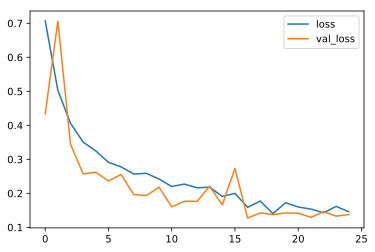

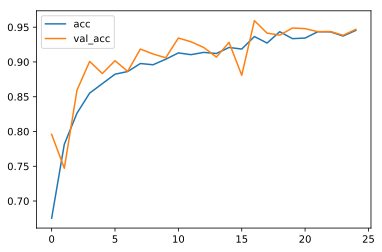

In [36]:
#
history_df = pandas.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [33]:
#对测试集进行预测

from keras.models import load_model

test_nan_df = pandas.read_csv('D:/data/Kaggle/Severstal/sample_submission.csv')

BATCH_SIZE = 64

test_gen = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_imgs,
        directory=r'D:\data\Kaggle\Severstal/test_imgs', #目标目录的路径，如果写了要包含在 dataframe 中映射的所有图像
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False #不打乱顺序
    )

model.load_weights('D:/data/Kaggle/Severstal/pre_model.h5')
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

test_nan_df['allMissing'] = y_test
test_nan_df.head(40)

NameError: name 'test_imgs' is not defined

In [48]:
from keras import backend as K

t1 = K.variable(np.array([[[1, 2],[2,3]],[[4,4], [5,3]]]))
t2 = K.variable(np.array([[[7, 4],[8,4]],[[2,10],[15,11]]]))
 
d0 = K.concatenate([t1,t2], axis=0)
d1 = K.concatenate([t1,t2], axis=1)
d2 = K.concatenate([t1,t2], axis=2)
d3 = K.concatenate([t1,t2], axis=-1)
#c3 = K.concatenate([a , b] , axis=3)

print('d0:',K.eval(d0),'\nd1:',K.eval(d1),'\nd2:',K.eval(d2),'\nd3:',K.eval(d3))

d0: [[[ 1.  2.]
  [ 2.  3.]]

 [[ 4.  4.]
  [ 5.  3.]]

 [[ 7.  4.]
  [ 8.  4.]]

 [[ 2. 10.]
  [15. 11.]]] 
d1: [[[ 1.  2.]
  [ 2.  3.]
  [ 7.  4.]
  [ 8.  4.]]

 [[ 4.  4.]
  [ 5.  3.]
  [ 2. 10.]
  [15. 11.]]] 
d2: [[[ 1.  2.  7.  4.]
  [ 2.  3.  8.  4.]]

 [[ 4.  4.  2. 10.]
  [ 5.  3. 15. 11.]]] 
d3: [[[ 1.  2.  7.  4.]
  [ 2.  3.  8.  4.]]

 [[ 4.  4.  2. 10.]
  [ 5.  3. 15. 11.]]]
